<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/TimeSeriesAnalysis_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab uses the labeled NY data from the following csv files:
* NY covid cases + mobility + population density + social distancing index (m50) + Mask rule  data and classified : **NY_labeledData_Aug27.csv**
* NY covid cases with social distancing inertia data from Marlyland university and classified : **NY_sd_inertia_labeledData_Aug27.csv**

Idea: 
* Do Time Series Analysis, Visualization & Forecasting with LSTM


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')


In [6]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_Covid-19.csv
CA-CovidAug22.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv


# 1.1 Loading NY Labeled data

In [7]:
NY_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Aug27.csv',low_memory=False)
NY_labeled_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label
0,2020-03-01,36001,Albany County,10.0000,13.0000,19.0000,4.0000,7.0000,-1.0000,-4.8700,2.6160,54,584.3650,0,0.0000,0,0.0000,LessSpread
1,2020-03-01,36003,Allegany County,47.0000,13.0000,0.0000,0.0000,1.0000,0.0000,19.8100,0.7070,12,44.7785,0,0.0000,0,0.0000,LessSpread
2,2020-03-01,36123,Yates County,31.0000,33.0000,0.0000,0.0000,7.0000,0.0000,28.1400,5.0040,72,73.6766,0,0.0000,0,0.0000,LessSpread
3,2020-03-01,36119,Westchester County,8.0000,-1.0000,12.0000,1.0000,0.0000,0.0000,-4.3400,3.9030,59,2247.4007,0,0.0000,0,0.0000,LessSpread
4,2020-03-01,36031,Essex County,16.0000,11.0000,17.0000,0.0000,1.0000,0.0000,60.1800,12.6000,197,20.5576,0,0.0000,0,0.0000,LessSpread


## Categorical Code

In [8]:
NY_labeled_data["label"] = NY_labeled_data["label"].astype('category')
NY_labeled_data['spread_category']= NY_labeled_data["label"].cat.codes

In [14]:
NY_labeled_data.head(4)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,spread_category
0,2020-03-01,36001,Albany County,10.0000,13.0000,19.0000,4.0000,7.0000,-1.0000,-4.8700,2.6160,54,584.3650,0,0.0000,0,0.0000,LessSpread,0
1,2020-03-01,36003,Allegany County,47.0000,13.0000,0.0000,0.0000,1.0000,0.0000,19.8100,0.7070,12,44.7785,0,0.0000,0,0.0000,LessSpread,0
2,2020-03-01,36123,Yates County,31.0000,33.0000,0.0000,0.0000,7.0000,0.0000,28.1400,5.0040,72,73.6766,0,0.0000,0,0.0000,LessSpread,0
3,2020-03-01,36119,Westchester County,8.0000,-1.0000,12.0000,1.0000,0.0000,0.0000,-4.3400,3.9030,59,2247.4007,0,0.0000,0,0.0000,LessSpread,0


## Train-Test Split

In [9]:
NY_labeled_data.columns

Index(['Date', 'fips_x', 'County Name', 'retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases', 'label', 'spread_category'],
      dtype='object')

In [10]:
X_cols = ['fips_x','retail and recreation',
       'grocery and pharmacy', 'parks', 'transit stations', 'workplaces',
       'residential', 'driving', 'm50', 'm50_index', 'population_density',
       'mask_rule_active', 'mask_wearing_percent', 'New cases',
       'rolling_avg_new_cases']

In [11]:
NY_labeled_data['Date'] =  pd.to_datetime(NY_labeled_data['Date'])

In [12]:
X = NY_labeled_data[X_cols]
Y = NY_labeled_data[['spread_category']]
Y.shape

(9690, 1)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8721, 15) (8721, 1)
(969, 15) (969, 1)


In [20]:
X_train.shape[0]

8721

## LSTM

In [14]:
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler

In [21]:
seq_len=X_train.shape[0]
day = 14
num_output = 3
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, day,num_output)))
model.add(Dense(1, activation='sigmoid'))

ValueError: ignored

In [18]:
model.summary()

ValueError: ignored

In [53]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train, Y_train, epochs=200, batch_size=128, callbacks=[chk], validation_data=(X_test, Y_test))

Epoch 1/200
69/69 [==============================] - 0s 3ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 2/200
69/69 [==============================] - 0s 1ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 3/200
69/69 [==============================] - 0s 1ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 4/200
69/69 [==============================] - 0s 1ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 5/200
69/69 [==============================] - 0s 1ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 6/200
69/69 [==============================] - 0s 1ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 7/200
69/69 [==============================] - 0s 1ms/step - loss: 8.5627 - accuracy: 0.8965 - val_loss: 8.5572 - val_accuracy: 0.9020
Epoch 8/200
6

## Accuracy

In [54]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

31/31 [==============================] - 0s 979us/step - loss: 8.5572 - accuracy: 0.9020
Test set
  Loss: 8.557
  Accuracy: 0.902


## Plot Loss and Accuracy

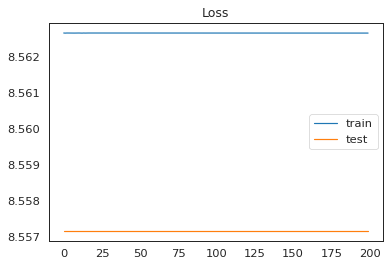

In [56]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

KeyError: ignored

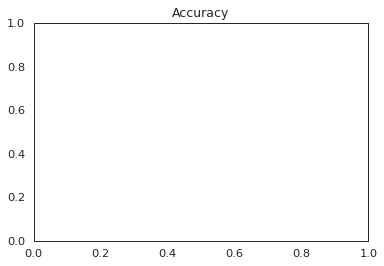

In [59]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# 2.1 Loading NY - Social Distancing Inertia Labeled data

In [61]:
NY_inertia_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_sd_inertia_labeledData_Aug27.csv',low_memory=False)
NY_inertia_labeled_data.head()

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.3200,40.3000,2.3000,35.4000,1.0600,3.2500,0,307117,0.4000,2020-01-22,6.0600,22,64535,11.7000,5.8000,48.4400,577,465,151,2.7400,0.2200,0.0290,37.0000,27,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread
1,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.2900,35.2000,0.4000,47.9000,1.0400,3.2500,0,61833,-0.7000,2020-01-22,1.0400,27,51862,1.1000,2.1000,49.4600,43,12,106,2.7400,0.2200,0.0290,37.0000,67,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread
2,2020-01-22,New York,36041,0,0,36041,Hamilton County,36,13,16,4.3100,37.6000,1.6000,67.0000,0.2800,4.0300,0,4434,7.0000,2020-01-22,0.3700,36,57552,0.8000,1.6000,51.3000,3,1,249,2.7400,0.2200,0.0290,37.0000,96,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread
3,2020-01-22,New York,36111,0,0,36111,Ulster County,36,17,21,4.2900,29.4000,1.9000,45.6000,0.9200,3.3800,0,178599,5.7000,2020-01-22,2.4700,26,63348,5.4000,10.0000,49.5100,154,86,144,2.7400,0.2200,0.0290,37.0000,59,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread
4,2020-01-22,New York,36039,0,0,36039,Greene County,36,15,17,4.2200,38.9000,2.3000,53.0000,0.9200,3.3000,0,47491,-4.0000,2020-01-22,1.1300,29,53617,5.8000,5.8000,52.3000,72,24,135,2.7400,0.2200,0.0290,37.0000,78,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread


## Categorical Code

In [62]:
NY_inertia_labeled_data["label"] = NY_inertia_labeled_data["label"].astype('category')
NY_inertia_labeled_data['spread_category']= NY_inertia_labeled_data["label"].cat.codes

In [63]:
NY_inertia_labeled_data.head(4)

,Date,Province_State,FIPS,New cases,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Confirmed,Deaths,New deaths,#days: decreasing ILI cases,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,Imported COVID cases,rolling_avg_new_cases,label,spread_category
0,2020-01-22,New York,36001,0,0,36001,Albany County,36,20,21,4.3200,40.3000,2.3000,35.4000,1.0600,3.2500,0,307117,0.4000,2020-01-22,6.0600,22,64535,11.7000,5.8000,48.4400,577,465,151,2.7400,0.2200,0.0290,37.0000,27,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,0
1,2020-01-22,New York,36043,0,0,36043,Herkimer County,36,16,20,4.2900,35.2000,0.4000,47.9000,1.0400,3.2500,0,61833,-0.7000,2020-01-22,1.0400,27,51862,1.1000,2.1000,49.4600,43,12,106,2.7400,0.2200,0.0290,37.0000,67,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,0
2,2020-01-22,New York,36041,0,0,36041,Hamilton County,36,13,16,4.3100,37.6000,1.6000,67.0000,0.2800,4.0300,0,4434,7.0000,2020-01-22,0.3700,36,57552,0.8000,1.6000,51.3000,3,1,249,2.7400,0.2200,0.0290,37.0000,96,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,0
3,2020-01-22,New York,36111,0,0,36111,Ulster County,36,17,21,4.2900,29.4000,1.9000,45.6000,0.9200,3.3800,0,178599,5.7000,2020-01-22,2.4700,26,63348,5.4000,10.0000,49.5100,154,86,144,2.7400,0.2200,0.0290,37.0000,59,0.0000,0.8000,3.7000,4.2000,0.7000,63.5000,0.0000,0.0000,0.0000,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,LessSpread,0


## Train-Test Split

In [64]:
NY_inertia_labeled_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'mask_rule_active',
       'CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
   

In [65]:
X_cols = ['FIPS', 'New cases', 'mask_rule_active',
       'CTFIPS', 'CTNAME', 'STFIPS', 'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person', 'New COVID cases', 'Population',
       '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage',
       'Confirmed', 'Deaths', 'New deaths', '#days: decreasing ILI cases',
       'COVID death rate', 'New cases/1000 people', 'Active cases/1000 people',
       '#days: decreasing COVID cases', 'Imported COVID cases',
       'rolling_avg_new_cases']

In [66]:
NY_inertia_labeled_data['Date'] =  pd.to_datetime(NY_inertia_labeled_data['Date'])

In [67]:
X = NY_inertia_labeled_data[X_cols]
Y = NY_inertia_labeled_data[['spread_category']]
Y.shape

(12296, 1)

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11066, 52) (11066, 1)
(1230, 52) (1230, 1)


## LSTM

In [ ]:
seq_len=60
model = Sequential()
model.add(LSTM(256, input_shape=(seq_len, 4)))
model.add(Dense(1, activation='sigmoid'))

In [70]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train, Y_train, epochs=200, batch_size=128, callbacks=[chk], validation_data=(X_test, Y_test))

ValueError: ignored

## Accuracy

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

31/31 [==============================] - 0s 979us/step - loss: 8.5572 - accuracy: 0.9020
Test set
  Loss: 8.557
  Accuracy: 0.902


## Plot Loss and Accuracy

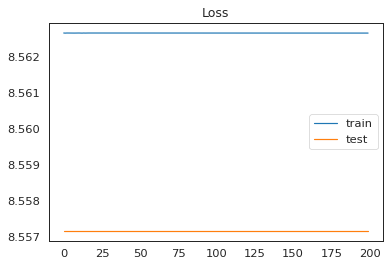

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

KeyError: ignored

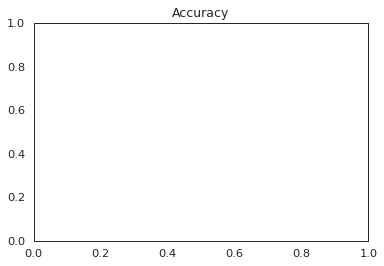

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

# Reference:

* https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/
* https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
* https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba